# Reconstrucción del campo de flujo en una cavidad cuadrada
## TP N°2: Modelado PINN
### Redes Neuronales Informadas por Física - Maestria en Inteligencia Artificial
#### Grupo N°4: Jorge Ceferino Valdez, Fabian Sarmiento y Trinidad Monreal.
---

Buscamos reconstruir el campo de flujo estacionario en una cavidad cuadrada usando una Red Neuronal Informada por Física (PINN). Se trata de resolver las ecuaciones de Navier-Stokes incomprensibles:

$$(\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \frac{1}{Re} \nabla^2 \mathbf{u} \text{,  en Ω}$$

$$\nabla \cdot \mathbf{u} = 0 \text{,  en Ω}$$

con las siguientes condiciones de borde:

- _No-slip_ en las fronteras laterales e inferior ($\mathbf{u} = (0,0)$)
- Velocidad constante en direccion $+x$ en la frontera superior ($\mathbf{u} = (1,0)$)

y $Ω = [0,1]⊗[0,1]$

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.io import loadmat
from scipy.interpolate import griddata

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc
from tqdm import trange

np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_name = "CUDA GPU"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

# Configurar semillas para reproducibilidad
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
elif torch.backends.mps.is_available():
    # MPS usa la misma semilla que PyTorch general
    torch.manual_seed(42)

print(f"Usando dispositivo: {device} ({device_name})")

Usando dispositivo: cuda:0 (CUDA GPU)


In [ ]:
# Crear un directorio para guardar las gráficas
graficas_dir = os.path.join("graficas", "tp2")

if not os.path.exists(graficas_dir):
    os.makedirs(graficas_dir)

### 1. Implementación básica de un esquema vanilla PINN para realizar el cómputo “directo” de las variables dependientes en estudio (en este caso, la presión 𝑝 y velocidades 𝑢 y 𝑣) 
_Implementar una rutina que incluya los pasos enumerados previamente. Tomar como referencia las implementaciones provistas por la cátedra (ver notebooks de Colab). Prestar especial atención al cómputo de las derivadas de la presión 𝑝 y velocidades 𝑢 y 𝑣 en función de las variables independientes, y a la construcción de los residuos correspondientes._

### 2. Resolver el sistema de ecuaciones del enunciado mediante PINN, sin emplear datos rotulados.
*Utilizar muestreos aleatorios tanto para el residuo de las PDE como para las condiciones de borde. Utilizar N<sub>pde</sub> = 10000 y N<sub>bc</sub> = 1000*

### Clase PINN Navier-stokes

In [3]:
class PINN_Module(nn.Module):
    """
    Red Neuronal Informada por Física para resolver las ecuaciones de Navier-Stokes
    en una cavidad cuadrada con lid-driven flow
    """
    
    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.Re = model_parameters["Re"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        
        # Definir arquitectura de la red
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) 
             for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        
        # Inicialización Xavier
        self.init_xavier()

    def forward(self, X):
        """
        Forward pass de la red neuronal
        Input: X tensor de forma (N, 2) con coordenadas (x, y)
        Output: tensor de forma (N, 3) con (u, v, p)
        """
        lb = self.LowerBounds
        ub = self.UpperBounds
        
        # Normalización de entradas a [-1, 1]
        X = 2 * (X - lb) / (ub - lb) - 1
        
        # Forward pass
        output = self.ActivationFunction(self.InputLayer(X))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        
        return output

    def init_xavier(self):
        """Inicialización Xavier mejorada de los pesos"""
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # Bias no cero para romper simetría
                torch.nn.init.uniform_(m.bias, -0.1, 0.1)
        
        self.apply(init_weights)

    def navierstokesResidue(self, X, uvp):
        """
        Calcula los residuos de las ecuaciones de Navier-Stokes
        
        Ecuaciones:
        (u·∇)u = -∇p + (1/Re)∇²u  →  u*∂u/∂x + v*∂u/∂y + ∂p/∂x - (1/Re)(∂²u/∂x² + ∂²u/∂y²) = 0
        (u·∇)v = -∇p + (1/Re)∇²v  →  u*∂v/∂x + v*∂v/∂y + ∂p/∂y - (1/Re)(∂²v/∂x² + ∂²v/∂y²) = 0
        ∇·u = ∂u/∂x + ∂v/∂y = 0
        """
        u = uvp[:, 0:1]  # velocidad en x
        v = uvp[:, 1:2]  # velocidad en y
        p = uvp[:, 2:3]  # presión
        
        Re = self.Re
        
        # Derivadas de primer orden usando autodiferenciación
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_x = diff_u[:, 0:1]
        u_y = diff_u[:, 1:2]
        
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        v_x = diff_v[:, 0:1]
        v_y = diff_v[:, 1:2]
        
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        p_x = diff_p[:, 0:1]
        p_y = diff_p[:, 1:2]
        
        # Derivadas de segundo orden
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Residuos de las ecuaciones de momentum
        residue_u = u * u_x + v * u_y + p_x - (1/Re) * (u_xx + u_yy)
        residue_v = u * v_x + v * v_y + p_y - (1/Re) * (v_xx + v_yy)
        
        # Residuo de continuidad
        residue_continuity = u_x + v_y
        
        return residue_u, residue_v, residue_continuity

#### Configuración del dominio y condiciones de borde

In [4]:
# Parámetros del problema
Re = 100.0  # Número de Reynolds
xi, xf = 0.0, 1.0  # Límites en x
yi, yf = 0.0, 1.0  # Límites en y

# Límites del dominio
lb = torch.tensor([xi, yi], device=device)  # Lower bounds
ub = torch.tensor([xf, yf], device=device)  # Upper bounds

# Condiciones de borde
u_wall = 0.0    # Velocidad en las paredes (no-slip)
v_wall = 0.0    # Velocidad normal en las paredes
u_lid = 1.0     # Velocidad de la tapa superior
v_lid = 0.0     # Velocidad normal en la tapa

print(f"Número de Reynolds: {Re}")
print(f"Dominio: [{xi}, {xf}] x [{yi}, {yf}]")
print(f"Condiciones de borde:")
print(f"  - Paredes laterales e inferior: u=v=0 (no-slip)")
print(f"  - Tapa superior: u={u_lid}, v={v_lid}")

Número de Reynolds: 100.0
Dominio: [0.0, 1.0] x [0.0, 1.0]
Condiciones de borde:
  - Paredes laterales e inferior: u=v=0 (no-slip)
  - Tapa superior: u=1.0, v=0.0


#### Carga de datos de ground-truth

In [5]:
# Cargar datos de los .mat
pressure_mat = loadmat('Re-100/pressure.mat')
velocity_mat = loadmat('Re-100/velocity.mat')

x = pressure_mat['x'].squeeze()
y = pressure_mat['y'].squeeze()
p = pressure_mat['p'].squeeze()
u = velocity_mat['u'].squeeze()
v = velocity_mat['v'].squeeze()

# Reconstruir grilla regular
x_unique = np.linspace(x.min(), x.max(), 201)
y_unique = np.linspace(y.min(), y.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolar campos sobre la grilla
U_grid = griddata((x, y), u, (X_grid, Y_grid), method='cubic')
V_grid = griddata((x, y), v, (X_grid, Y_grid), method='cubic')
P_grid = griddata((x, y), p, (X_grid, Y_grid), method='cubic')

# Preparar puntos para evaluación del modelo
X_eval = torch.tensor(np.stack([X_grid.flatten(), Y_grid.flatten()], axis=1), dtype=torch.float32, device=device)

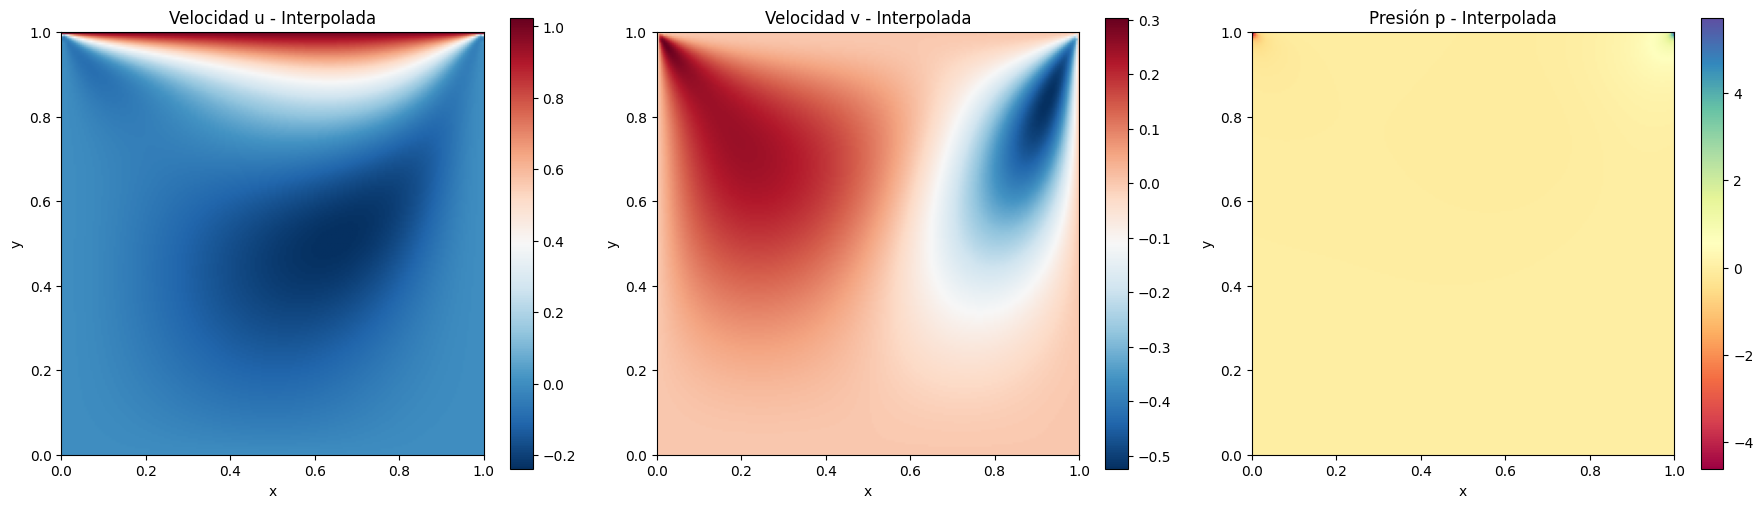

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Campo u
im0 = axs[0].imshow(U_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[0].set_title("Velocidad u - Interpolada")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(im0, ax=axs[0])

# Campo v
im1 = axs[1].imshow(V_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[1].set_title("Velocidad v - Interpolada")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(im1, ax=axs[1])

# Campo p
im2 = axs[2].imshow(P_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='Spectral', aspect='equal')
axs[2].set_title("Presión p - Interpolada")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

#### Generación de puntos de colocación 

In [7]:
def sample_training_points(N_pde, N_bc, device):
    """
    Genera puntos de colocación para PINNs:
    - Puntos interiores (PDE)
    - Puntos de borde (BC): bottom, top, left, right
    """
    # PDE points en el dominio [0,1] x [0,1]
    pde_points = torch.rand(N_pde, 2, device=device)

    # Puntos de borde
    N_each = N_bc // 4
    rand = torch.rand(N_each, device=device)

    bottom = torch.stack([rand, torch.zeros_like(rand)], dim=1)
    top    = torch.stack([rand, torch.ones_like(rand)], dim=1)
    left   = torch.stack([torch.zeros_like(rand), rand], dim=1)
    right  = torch.stack([torch.ones_like(rand), rand], dim=1)

    bc_points = torch.cat([bottom, top, left, right], dim=0)

    return pde_points, bottom, top, left, right, bc_points

In [8]:
N_pde = 10000
N_bc = 1000

print(f"Generando puntos de colocación:")
pde_points, bottom, top, left, right, bc_points = sample_training_points(N_pde, N_bc, device)
print(f"  - N_pde = {N_pde}")
print(f"  - N_bc = {N_bc} (divididos en 4 bordes)")
print(f"Puntos generados exitosamente")

Generando puntos de colocación:
  - N_pde = 10000
  - N_bc = 1000 (divididos en 4 bordes)
Puntos generados exitosamente


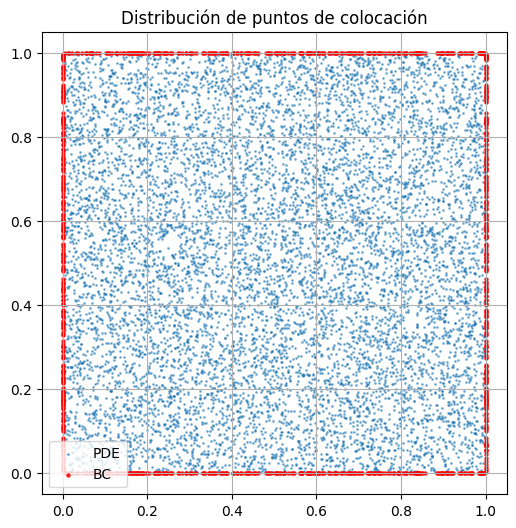

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(pde_points[:,0].cpu(), pde_points[:,1].cpu(), s=1, label='PDE', alpha=0.5)
plt.scatter(bc_points[:,0].cpu(), bc_points[:,1].cpu(), s=5, label='BC', color='red', alpha=0.8)
plt.legend()
plt.title("Distribución de puntos de colocación")
plt.grid(True)
plt.show()

#### Configuración del modelo

In [ ]:
# Parámetros del modelo
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "Re": Re,
    "InputDimensions": 2,      # (x, y)
    "OutputDimensions": 3,     # (u, v, p)
    "NumberOfNeurons": 64,    
    "NumberOfHiddenLayers": 5, 
    "ActivationFunction": nn.GELU() 
}

In [11]:
# Crear modelo
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)

print("Arquitectura del modelo:")
print(f"  - Entradas: {model_parameters['InputDimensions']} (x, y)")
print(f"  - Salidas: {model_parameters['OutputDimensions']} (u, v, p)")
print(f"  - Capas ocultas: {model_parameters['NumberOfHiddenLayers']}")
print(f"  - Neuronas por capa: {model_parameters['NumberOfNeurons']}")
print(f"  - Función de activación: {model_parameters['ActivationFunction']}")

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  - Total de parámetros entrenables: {total_params}")

Arquitectura del modelo:
  - Entradas: 2 (x, y)
  - Salidas: 3 (u, v, p)
  - Capas ocultas: 5
  - Neuronas por capa: 64
  - Función de activación: GELU(approximate='none')
  - Total de parámetros entrenables: 17027


### Entrenamiento

In [12]:
def compute_bc_loss(uvp, u_target, v_target, loss_fn):
    loss_u = loss_fn(uvp[:, 0:1], u_target)
    loss_v = loss_fn(uvp[:, 1:2], v_target)
    return loss_u + loss_v

# Función para calcular pérdida de presión de referencia
def compute_pressure_reference_loss(model, loss_fn):
    """
    Calcula la pérdida para forzar que p(0,0) = 0
    Esto elimina la indeterminación de la constante en el campo de presión
    """
    # Punto de referencia (0,0)
    reference_point = torch.tensor([[0.0, 0.0]], device=device, requires_grad=True)
    
    # Evaluar el modelo en el punto de referencia
    uvp_ref = model(reference_point)
    p_ref = uvp_ref[:, 2:3]  # Extraer presión
    
    # La presión en (0,0) debe ser cero
    target_pressure = torch.zeros_like(p_ref)
    
    return loss_fn(p_ref, target_pressure)

# Función de entrenamiento
def train_pinn(model, pde_points, top, bottom, left, right, 
               epochs, optimizer, scheduler,
               weight_pde, initial_weight_bc, final_weight_bc,
               weight_pressure_ref,  # agregado el peso para condición de referencia
               loss_fn=nn.MSELoss()):

    # Historial de pérdidas (agregamos nueva pérdida)
    loss_train = []
    loss_train_momentum_u = []
    loss_train_momentum_v = []
    loss_train_continuity = []
    loss_train_bc = []
    loss_train_pressure_ref = []  # agregamos al historial la pérdida de referencia

    print("Iniciando entrenamiento ...")
    t0 = datetime.now()

    for epoch in trange(epochs, desc="Entrenando modelo PINN"):
        progress = epoch / epochs
        current_weight_bc = initial_weight_bc * (1 - progress) + final_weight_bc * progress

        model.train()
        optimizer.zero_grad()

        # === PDE ===
        pde_points_epoch = pde_points.detach().clone().requires_grad_(True)
        uvp_pde = model(pde_points_epoch)
        res_u, res_v, res_cont = model.navierstokesResidue(pde_points_epoch, uvp_pde)

        # Pérdidas PDE (los residuos deben ser cero)
        loss_u = loss_fn(res_u, torch.zeros_like(res_u))
        loss_v = loss_fn(res_v, torch.zeros_like(res_v))
        loss_cont = loss_fn(res_cont, torch.zeros_like(res_cont))

        loss_pde_total = loss_u + loss_v + loss_cont

        # === BC ===
        uvp_top = model(top)
        uvp_bottom = model(bottom)
        uvp_left = model(left)
        uvp_right = model(right)

        loss_bc_top = compute_bc_loss(uvp_top,
                                      torch.ones_like(uvp_top[:, 0:1]),
                                      torch.zeros_like(uvp_top[:, 1:2]),
                                      loss_fn)
        loss_bc_bottom = compute_bc_loss(uvp_bottom,
                                         torch.zeros_like(uvp_bottom[:, 0:1]),
                                         torch.zeros_like(uvp_bottom[:, 1:2]),
                                         loss_fn)
        loss_bc_left = compute_bc_loss(uvp_left,
                                       torch.zeros_like(uvp_left[:, 0:1]),
                                       torch.zeros_like(uvp_left[:, 1:2]),
                                       loss_fn)
        loss_bc_right = compute_bc_loss(uvp_right,
                                        torch.zeros_like(uvp_right[:, 0:1]),
                                        torch.zeros_like(uvp_right[:, 1:2]),
                                        loss_fn)

        loss_bc_total = loss_bc_top + loss_bc_bottom + loss_bc_left + loss_bc_right

        # === Presión de referencia ===
        loss_pressure_ref = compute_pressure_reference_loss(model, loss_fn)

        # === Función de pérdida total ===
        loss_total = (weight_pde * loss_pde_total +
                     current_weight_bc * loss_bc_total +
                     weight_pressure_ref * loss_pressure_ref)  # agregado nuevo término

        # Backpropagation
        loss_total.backward()
        optimizer.step()
        scheduler.step()

        # Guardar pérdidas
        loss_train.append(loss_total.item())
        loss_train_momentum_u.append(loss_u.item())
        loss_train_momentum_v.append(loss_v.item())
        loss_train_continuity.append(loss_cont.item())
        loss_train_bc.append(loss_bc_total.item())
        loss_train_pressure_ref.append(loss_pressure_ref.item())  # agregado al historial

        # Log del progreso (incluida nueva pérdida)
        if epoch % 500 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                u_top_mean = model(top)[:, 0].mean().item()
                # Verificar presión en (0,0)
                ref_point = torch.tensor([[0.0, 0.0]], device=device)
                p_ref_value = model(ref_point)[0, 2].item()

            print(f"Epoch {epoch:4d} | Total: {loss_total.item():.2e} | PDE: {loss_pde_total.item():.2e} | "
                  f"BC: {loss_bc_total.item():.2e} | P_ref: {loss_pressure_ref.item():.2e} | "
                  f"p(0,0): {p_ref_value:.4f} | u_top: {u_top_mean:.3f}")

    elapsed = datetime.now() - t0
    print(f"\nTiempo total: {elapsed.total_seconds():.1f} segundos")

    models_dir = "models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
        
    # Guardar modelo
    torch.save(model.state_dict(), f"models/pinn_trained_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

    # Retornar historial (MODIFICADO)
    return {
        "total": loss_train,
        "u_momentum": loss_train_momentum_u,
        "v_momentum": loss_train_momentum_v,
        "continuity": loss_train_continuity,
        "bc": loss_train_bc,
        "pressure_ref": loss_train_pressure_ref  # NUEVO
    }

#### Gráficos de evolución de pérdidas

In [13]:
# Función para graficar pérdidas con nueva pérdida
def plot_losses(loss_dict):
    loss_list = [
        loss_dict["total"],
        loss_dict["u_momentum"],
        loss_dict["v_momentum"],
        loss_dict["continuity"],
        loss_dict["bc"],
        loss_dict["pressure_ref"]  # NUEVO
    ]
    colors = ['black', 'red', 'green', 'blue', 'magenta', 'orange']  # NUEVO color
    titles = ['Overall Loss', 'Momentum U', 'Momentum V', 'Continuity', 'BC', 'Pressure Ref']  # NUEVO título

    fig, ax = plt.subplots(1, len(loss_list), figsize=(25, 4))
    for i, loss in enumerate(loss_list):
        ax[i].loglog(np.arange(len(loss)), loss, color=colors[i])
        ax[i].set_xlabel("Epoch")
        ax[i].set_title(titles[i])
        ax[i].grid(True)
    plt.tight_layout()
    # Guardamos las gráficas en el directorio creado
    plt.savefig(f'{graficas_dir}/graficas_de_perdidas.png')
    plt.show()

Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 1/10000 [00:00<20:52,  7.99it/s]

Epoch    0 | Total: 4.83e+03 | PDE: 1.48e+00 | BC: 8.99e-01 | P_ref: 1.87e-02 | p(0,0): 0.0683 | u_top: 0.602


Entrenando modelo PINN:   5%|▌         | 508/10000 [00:08<02:39, 59.63it/s]

Epoch  500 | Total: 3.42e+02 | PDE: 2.74e-01 | BC: 6.54e-02 | P_ref: 3.22e-06 | p(0,0): -0.0018 | u_top: 0.813


Entrenando modelo PINN:  10%|█         | 1009/10000 [00:17<02:42, 55.46it/s]

Epoch 1000 | Total: 1.11e+02 | PDE: 1.91e-01 | BC: 1.99e-02 | P_ref: 2.07e-07 | p(0,0): 0.0005 | u_top: 0.976


Entrenando modelo PINN:  15%|█▌        | 1510/10000 [00:25<02:22, 59.41it/s]

Epoch 1500 | Total: 8.28e+01 | PDE: 1.71e-01 | BC: 1.49e-02 | P_ref: 8.25e-06 | p(0,0): 0.0030 | u_top: 0.982


Entrenando modelo PINN:  20%|██        | 2013/10000 [00:33<02:10, 61.40it/s]

Epoch 2000 | Total: 6.22e+01 | PDE: 1.29e-01 | BC: 1.17e-02 | P_ref: 7.26e-09 | p(0,0): 0.0001 | u_top: 0.991


Entrenando modelo PINN:  25%|██▌       | 2508/10000 [00:42<02:14, 55.87it/s]

Epoch 2500 | Total: 4.80e+01 | PDE: 1.09e-01 | BC: 9.27e-03 | P_ref: 2.22e-07 | p(0,0): -0.0005 | u_top: 0.971


Entrenando modelo PINN:  30%|███       | 3011/10000 [00:51<01:59, 58.49it/s]

Epoch 3000 | Total: 3.68e+01 | PDE: 8.38e-02 | BC: 7.49e-03 | P_ref: 8.84e-07 | p(0,0): 0.0009 | u_top: 0.979


Entrenando modelo PINN:  35%|███▌      | 3510/10000 [00:59<01:56, 55.71it/s]

Epoch 3500 | Total: 3.00e+01 | PDE: 6.40e-02 | BC: 6.55e-03 | P_ref: 8.98e-07 | p(0,0): -0.0010 | u_top: 0.994


Entrenando modelo PINN:  40%|████      | 4008/10000 [01:08<01:41, 58.85it/s]

Epoch 4000 | Total: 2.59e+01 | PDE: 5.18e-02 | BC: 6.00e-03 | P_ref: 3.17e-05 | p(0,0): -0.0047 | u_top: 0.994


Entrenando modelo PINN:  45%|████▌     | 4509/10000 [01:16<01:34, 57.90it/s]

Epoch 4500 | Total: 2.17e+01 | PDE: 4.38e-02 | BC: 5.42e-03 | P_ref: 6.03e-07 | p(0,0): 0.0008 | u_top: 0.995


Entrenando modelo PINN:  50%|█████     | 5007/10000 [01:25<01:24, 59.10it/s]

Epoch 5000 | Total: 1.87e+01 | PDE: 3.70e-02 | BC: 5.01e-03 | P_ref: 1.79e-07 | p(0,0): -0.0005 | u_top: 0.994


Entrenando modelo PINN:  55%|█████▌    | 5508/10000 [01:34<01:16, 58.95it/s]

Epoch 5500 | Total: 1.64e+01 | PDE: 3.17e-02 | BC: 4.74e-03 | P_ref: 2.21e-07 | p(0,0): 0.0005 | u_top: 0.993


Entrenando modelo PINN:  60%|██████    | 6011/10000 [01:42<01:08, 58.63it/s]

Epoch 6000 | Total: 1.46e+01 | PDE: 2.76e-02 | BC: 4.55e-03 | P_ref: 1.63e-07 | p(0,0): -0.0004 | u_top: 0.994


Entrenando modelo PINN:  65%|██████▌   | 6512/10000 [01:51<01:02, 56.01it/s]

Epoch 6500 | Total: 1.30e+01 | PDE: 2.42e-02 | BC: 4.41e-03 | P_ref: 1.54e-07 | p(0,0): -0.0004 | u_top: 0.993


Entrenando modelo PINN:  70%|███████   | 7010/10000 [02:00<00:52, 57.11it/s]

Epoch 7000 | Total: 1.15e+01 | PDE: 2.09e-02 | BC: 4.30e-03 | P_ref: 4.21e-09 | p(0,0): -0.0000 | u_top: 0.994


Entrenando modelo PINN:  75%|███████▌  | 7511/10000 [02:09<00:45, 54.41it/s]

Epoch 7500 | Total: 1.02e+01 | PDE: 1.80e-02 | BC: 4.21e-03 | P_ref: 1.83e-08 | p(0,0): 0.0001 | u_top: 0.994


Entrenando modelo PINN:  80%|████████  | 8007/10000 [02:18<00:32, 61.03it/s]

Epoch 8000 | Total: 8.98e+00 | PDE: 1.55e-02 | BC: 4.12e-03 | P_ref: 9.91e-07 | p(0,0): 0.0010 | u_top: 0.994


Entrenando modelo PINN:  85%|████████▌ | 8508/10000 [02:26<00:26, 55.60it/s]

Epoch 8500 | Total: 7.80e+00 | PDE: 1.33e-02 | BC: 4.04e-03 | P_ref: 1.50e-07 | p(0,0): -0.0004 | u_top: 0.994


Entrenando modelo PINN:  90%|█████████ | 9009/10000 [02:35<00:18, 55.02it/s]

Epoch 9000 | Total: 6.69e+00 | PDE: 1.12e-02 | BC: 3.98e-03 | P_ref: 4.56e-09 | p(0,0): 0.0001 | u_top: 0.994


Entrenando modelo PINN:  95%|█████████▌| 9512/10000 [02:44<00:08, 58.77it/s]

Epoch 9500 | Total: 5.64e+00 | PDE: 9.39e-03 | BC: 3.92e-03 | P_ref: 1.52e-10 | p(0,0): 0.0000 | u_top: 0.994


Entrenando modelo PINN: 100%|██████████| 10000/10000 [02:52<00:00, 57.91it/s]


Epoch 9999 | Total: 4.66e+00 | PDE: 7.75e-03 | BC: 3.88e-03 | P_ref: 5.55e-17 | p(0,0): -0.0000 | u_top: 0.995

Tiempo total: 172.7 segundos


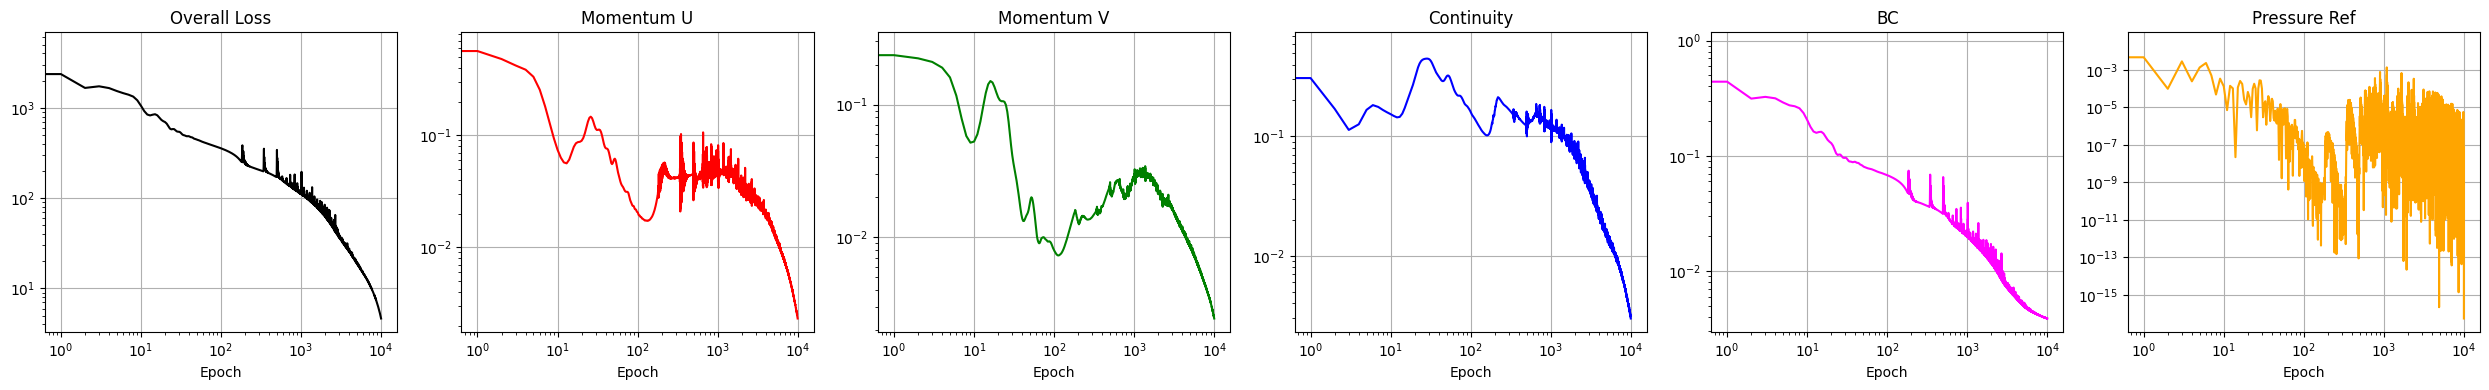

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0017834604711425984, weight_decay=5.291425845841764e-07) # Definidos con optuna
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9996901505905309)  # Decay gradual

losses = train_pinn(
                    model, pde_points, top, bottom, left, right,
                    epochs=10000,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    weight_pde=100.0,
                    initial_weight_bc=5000.0,
                    final_weight_bc=1000.0,
                    weight_pressure_ref=10000.0 
                    )

plot_losses(losses)

In [15]:
# Verificación final de condiciones de borde
print("\n=== VERIFICACIÓN FINAL DE CONDICIONES DE BORDE ===")
with torch.no_grad():
    # Verificar condición lid-driven
    uvp_top_final = model(top)
    u_top_mean = uvp_top_final[:, 0].mean().item()
    u_top_std = uvp_top_final[:, 0].std().item()
    v_top_mean = uvp_top_final[:, 1].mean().item()
    
    # Verificar condiciones no-slip
    uvp_bottom_final = model(bottom)
    u_bottom_mean = uvp_bottom_final[:, 0].mean().item()
    v_bottom_mean = uvp_bottom_final[:, 1].mean().item()
    
    print(f"Borde superior (lid-driven):")
    print(f"  u: {u_top_mean:.6f} ± {u_top_std:.6f} (objetivo: 1.0)")
    print(f"  v: {v_top_mean:.6f} (objetivo: 0.0)")
    print(f"Borde inferior (no-slip):")
    print(f"  u: {u_bottom_mean:.6f} (objetivo: 0.0)")
    print(f"  v: {v_bottom_mean:.6f} (objetivo: 0.0)")
    
    # Status de convergencia de BC
    if abs(u_top_mean - 1.0) < 0.1:
        print("✓ Condición lid-driven SATISFECHA")
    else:
        print("⚠ Condición lid-driven NO satisfecha")
    
    if abs(u_bottom_mean) < 0.05 and abs(v_bottom_mean) < 0.05:
        print("✓ Condición no-slip SATISFECHA")  
    else:
        print("⚠ Condición no-slip NO satisfecha")



=== VERIFICACIÓN FINAL DE CONDICIONES DE BORDE ===
Borde superior (lid-driven):
  u: 0.994740 ± 0.034957 (objetivo: 1.0)
  v: 0.001133 (objetivo: 0.0)
Borde inferior (no-slip):
  u: 0.000108 (objetivo: 0.0)
  v: 0.000077 (objetivo: 0.0)
✓ Condición lid-driven SATISFECHA
✓ Condición no-slip SATISFECHA


In [16]:
# Verificación específica de la condición de referencia
print("\n=== VERIFICACIÓN DE CONDICIÓN DE REFERENCIA ===")
with torch.no_grad():
    ref_point = torch.tensor([[0.0, 0.0]], device=device)
    uvp_ref_final = model(ref_point)
    p_ref_final = uvp_ref_final[0, 2].item()
    
    print(f"Presión en (0,0): {p_ref_final:.6f} (objetivo: 0.0)")
    
    if abs(p_ref_final) < 0.01:
        print("✓ Condición de referencia SATISFECHA")
    else:
        print("⚠ Condición de referencia NO satisfecha - aumentar weight_pressure_ref")


=== VERIFICACIÓN DE CONDICIÓN DE REFERENCIA ===
Presión en (0,0): -0.000002 (objetivo: 0.0)
✓ Condición de referencia SATISFECHA


### 3. Calcular la norma-2 del error entre los valores de presión 𝑝⋅y velocidades (𝑢⋅, 𝑣⋅) que predice el modelo y sus correspondientes valores ground-truth. 
_Para ello, computar los campos de presión y velocidad en la misma grilla de puntos que la empleada en la solución de referencia._

In [17]:
print("Realizando predicción en la malla regular...")

# Predicción del modelo en los puntos de evaluación (X_eval ya tiene 201x201 puntos aplanados)
with torch.no_grad():
    uvp_pred = model(X_eval)

# Separar componentes y reordenar en grillas 201x201
u_pred = uvp_pred[:, 0].cpu().numpy().reshape(201, 201)
v_pred = uvp_pred[:, 1].cpu().numpy().reshape(201, 201)
p_pred = uvp_pred[:, 2].cpu().numpy().reshape(201, 201)

print("Predicción completada")

# Calcular errores absolutos punto a punto
error_u = np.abs(u_pred - U_grid)
error_v = np.abs(v_pred - V_grid)
error_p = np.abs(p_pred - P_grid)

# Calcular normas-2 de los errores
norm2_error_u = np.linalg.norm(error_u)
norm2_error_v = np.linalg.norm(error_v)
norm2_error_p = np.linalg.norm(error_p)

# Calcular normas-2 de las soluciones de referencia para error relativo
norm2_ref_u = np.linalg.norm(U_grid)
norm2_ref_v = np.linalg.norm(V_grid)
norm2_ref_p = np.linalg.norm(P_grid)

# Errores relativos
rel_error_u = norm2_error_u / norm2_ref_u * 100
rel_error_v = norm2_error_v / norm2_ref_v * 100
rel_error_p = norm2_error_p / norm2_ref_p * 100

# Mostrar resultados
print("=== ANÁLISIS DE ERRORES (NORMA-2) ===")
print(f"Norma-2 del error absoluto:")
print(f"  - Velocidad u: {norm2_error_u:.6e}")
print(f"  - Velocidad v: {norm2_error_v:.6e}")
print(f"  - Presión p:   {norm2_error_p:.6e}")
print(f"\nError relativo (%):")
print(f"  - Velocidad u: {rel_error_u:.2f}%")
print(f"  - Velocidad v: {rel_error_v:.2f}%")
print(f"  - Presión p:   {rel_error_p:.2f}%")

Realizando predicción en la malla regular...
Predicción completada
=== ANÁLISIS DE ERRORES (NORMA-2) ===
Norma-2 del error absoluto:
  - Velocidad u: 3.253937e+00
  - Velocidad v: 3.381113e+00
  - Presión p:   5.562138e+00

Error relativo (%):
  - Velocidad u: 7.40%
  - Velocidad v: 11.35%
  - Presión p:   27.06%


### 4. Graficar el error absoluto entre los valores de presión 𝑝⋅ y velocidades (𝑢⋅, 𝑣⋅) que predice el modelo y sus correspondientes valores medidos (utilizando la misma grilla que en el punto anterior).

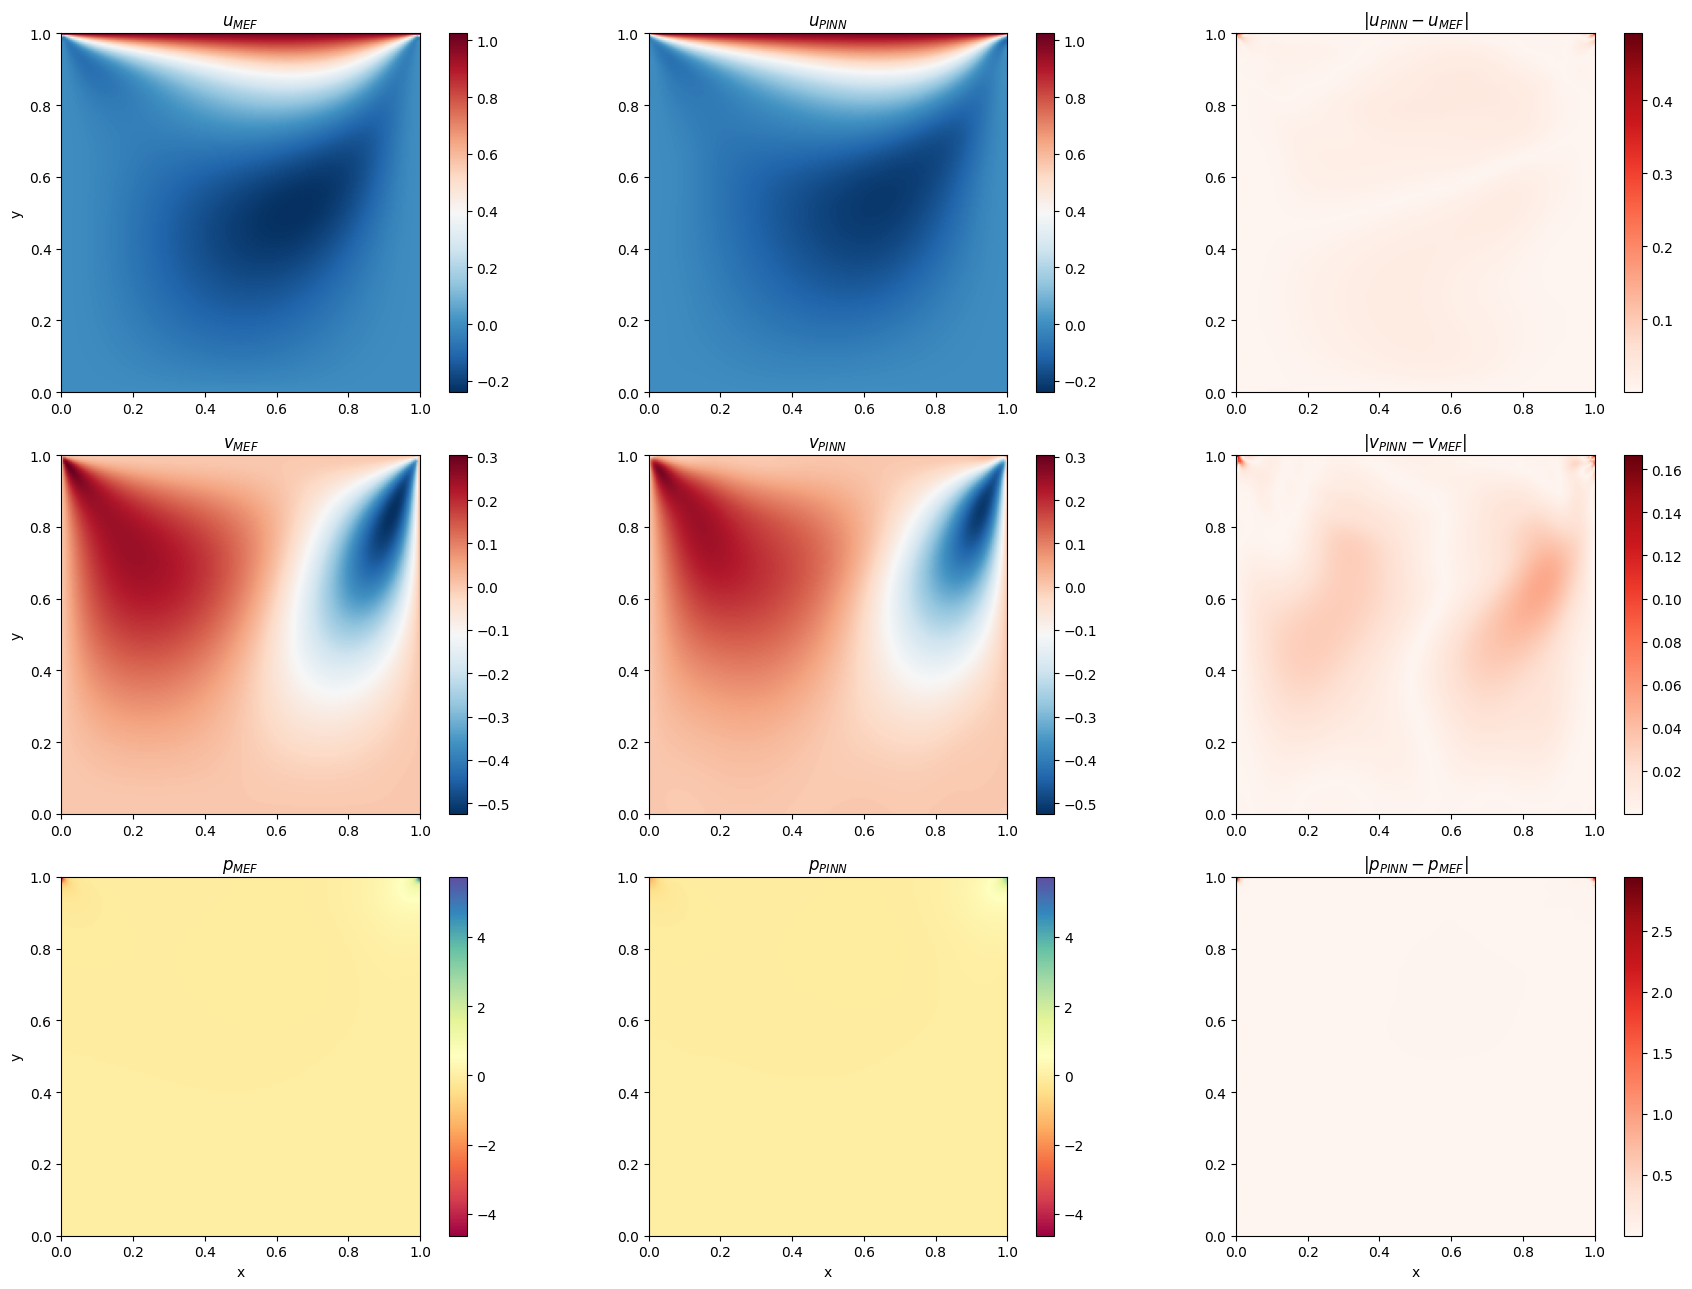

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(18, 13))

# --- Velocidad u ---
# u_ref (MEF)
im0 = axs[0, 0].imshow(U_grid, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdBu_r', aspect='equal')
axs[0, 0].set_title(r"$u_{MEF}$")
axs[0, 0].set_ylabel("y")
plt.colorbar(im0, ax=axs[0, 0])

# u_pred
#im1 = axs[0, 1].imshow(u_pred, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdBu_r', aspect='equal')
im1 = axs[0, 1].imshow(u_pred, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdBu_r', aspect='equal', vmin=U_grid.min(), vmax=U_grid.max())  # ← SINCRONIZACIÓN
axs[0, 1].set_title(r"$u_{PINN}$")
plt.colorbar(im1, ax=axs[0, 1])

# error_u
im2 = axs[0, 2].imshow(np.abs(u_pred - U_grid), extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Reds', aspect='equal')
axs[0, 2].set_title(r"$|u_{PINN} - u_{MEF}|$")
plt.colorbar(im2, ax=axs[0, 2])

# --- Velocidad v ---
# v_ref
im3 = axs[1, 0].imshow(V_grid, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdBu_r', aspect='equal')
axs[1, 0].set_title(r"$v_{MEF}$")
axs[1, 0].set_ylabel("y")
plt.colorbar(im3, ax=axs[1, 0])

# v_pred
#im4 = axs[1, 1].imshow(v_pred, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdBu_r', aspect='equal')
im4 = axs[1, 1].imshow(v_pred, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdBu_r', aspect='equal',vmin=V_grid.min(), vmax=V_grid.max())  # ← SINCRONIZACIÓN
axs[1, 1].set_title(r"$v_{PINN}$")
plt.colorbar(im4, ax=axs[1, 1])

# error_v
im5 = axs[1, 2].imshow(np.abs(v_pred - V_grid), extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Reds', aspect='equal')
axs[1, 2].set_title(r"$|v_{PINN} - v_{MEF}|$")
plt.colorbar(im5, ax=axs[1, 2])

# --- Presion p ---
# p_ref
im6 = axs[2, 0].imshow(P_grid, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Spectral', aspect='equal')
axs[2, 0].set_title(r"$p_{MEF}$")
axs[2, 0].set_ylabel("y")
axs[2, 0].set_xlabel("x")
plt.colorbar(im6, ax=axs[2, 0])

# p_pred
#im7 = axs[2, 1].imshow(p_pred, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Spectral', aspect='equal')
im7 = axs[2, 1].imshow(p_pred, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Spectral', aspect='equal',vmin=P_grid.min(), vmax=P_grid.max())  # ← SINCRONIZACIÓN
axs[2, 1].set_title(r"$p_{PINN}$")
axs[2, 1].set_xlabel("x")
plt.colorbar(im7, ax=axs[2, 1])

# error_p
im8 = axs[2, 2].imshow(np.abs(p_pred - P_grid), extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Reds', aspect='equal')
axs[2, 2].set_title(r"$|p_{PINN} - p_{MEF}|$")
axs[2, 2].set_xlabel("x")
plt.colorbar(im8, ax=axs[2, 2])

plt.tight_layout()
plt.savefig(f'{graficas_dir}/comparacion_u_v_p_total.png')
plt.show()


#### Análisis de perfiles en líneas características

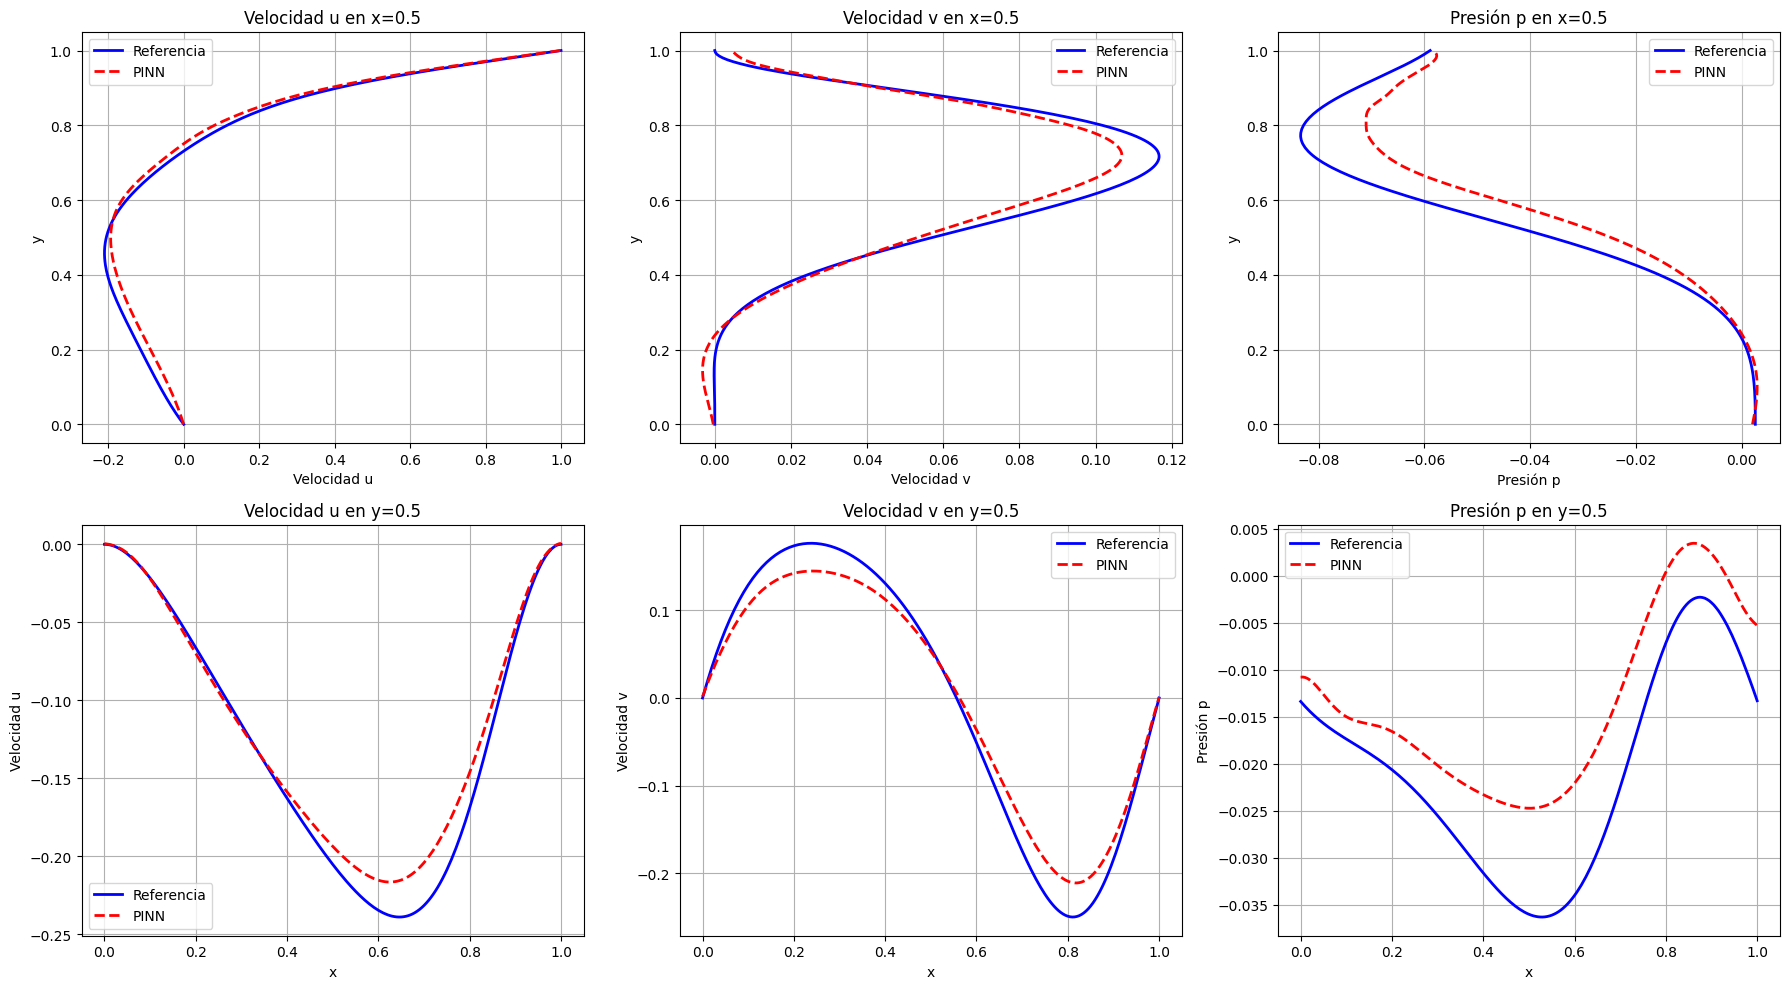

In [19]:
# Índices centrales de la malla
x_center_idx = 100  # x=0.5 en grilla de 201 puntos
y_center_idx = 100  # y=0.5 en grilla de 201 puntos

# Ejes
x_line = X_grid[0, :]  # valores de x a lo largo de una fila
y_line = Y_grid[:, 0]  # valores de y a lo largo de una columna

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# --- FILA SUPERIOR: cortes verticales en x=0.5 (vs y) ---
axs[0, 0].plot(U_grid[:, x_center_idx], y_line, 'b-', linewidth=2, label='Referencia')
axs[0, 0].plot(u_pred[:, x_center_idx], y_line, 'r--', linewidth=2, label='PINN')
axs[0, 0].set_xlabel('Velocidad u')
axs[0, 0].set_ylabel('y')
axs[0, 0].set_title('Velocidad u en x=0.5')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(V_grid[:, x_center_idx], y_line, 'b-', linewidth=2, label='Referencia')
axs[0, 1].plot(v_pred[:, x_center_idx], y_line, 'r--', linewidth=2, label='PINN')
axs[0, 1].set_xlabel('Velocidad v')
axs[0, 1].set_ylabel('y')
axs[0, 1].set_title('Velocidad v en x=0.5')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[0, 2].plot(P_grid[:, x_center_idx], y_line, 'b-', linewidth=2, label='Referencia')
axs[0, 2].plot(p_pred[:, x_center_idx], y_line, 'r--', linewidth=2, label='PINN')
axs[0, 2].set_xlabel('Presión p')
axs[0, 2].set_ylabel('y')
axs[0, 2].set_title('Presión p en x=0.5')
axs[0, 2].legend()
axs[0, 2].grid(True)

# --- FILA INFERIOR: cortes horizontales en y=0.5 (vs x) ---
axs[1, 0].plot(x_line, U_grid[y_center_idx, :], 'b-', linewidth=2, label='Referencia')
axs[1, 0].plot(x_line, u_pred[y_center_idx, :], 'r--', linewidth=2, label='PINN')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('Velocidad u')
axs[1, 0].set_title('Velocidad u en y=0.5')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(x_line, V_grid[y_center_idx, :], 'b-', linewidth=2, label='Referencia')
axs[1, 1].plot(x_line, v_pred[y_center_idx, :], 'r--', linewidth=2, label='PINN')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Velocidad v')
axs[1, 1].set_title('Velocidad v en y=0.5')
axs[1, 1].legend()
axs[1, 1].grid(True)

axs[1, 2].plot(x_line, P_grid[y_center_idx, :], 'b-', linewidth=2, label='Referencia')
axs[1, 2].plot(x_line, p_pred[y_center_idx, :], 'r--', linewidth=2, label='PINN')
axs[1, 2].set_xlabel('x')
axs[1, 2].set_ylabel('Presión p')
axs[1, 2].set_title('Presión p en y=0.5')
axs[1, 2].legend()
axs[1, 2].grid(True)

plt.tight_layout()
plt.savefig(f'{graficas_dir}/perfiles_lineas_caracteristicas.png')
plt.show()

### 5. Evaluación y análisis del modelo desarrollado

_En base al grado de convergencia obtenido durante el entrenamiento y los gráficos de error ¿Considera que el modelo desarrollado es suficientemente “bueno” para predecir los campos de presión y velocidad? ¿Qué fallas observa? ¿Qué aspectos positivos destaca? ¿Considera que los hiperparámetros que definió son adecuados? ¿Puede mejorarse el desempeño del modelo? En caso afirmativo ¿Qué acciones de mejoras se podrían implementar?_

**¿Considera que el modelo desarrollado es suficientemente “bueno” para predecir los campos de presión y velocidad?**

Sí. El modelo PINN desarrollado logra predecir de forma precisa la estructura del flujo en la cavidad. En particular, las predicciones de las velocidades `u` y `v` reproducen con alta fidelidad tanto la forma como las magnitudes de referencia, incluso en regiones con gradientes pronunciados. El campo de presión, que antes mostraba un sesgo constante, se corrigió al incorporar en la función de pérdida la condición `p(0,0) = 0`, eliminando así la indeterminación de la constante aditiva propia de este tipo de problemas. Esto permitió alinear correctamente la predicción con la solución de referencia.


Las gráficas de error absoluto confirman que las diferencias se mantienen en valores bajos en todo el dominio. Además, el modelo respeta rigurosamente las condiciones de borde: la condición lid-driven se cumple con un valor medio de `u ≈ 0.995 ± 0.035`, y el resto de los bordes muestran `u` y `v` cercanos a cero, como es esperable.

**¿Qué fallas observa?**

* Persisten leves errores localizados en la presión en zonas donde el gradiente es elevado, aunque en valores muy inferiores respecto a versiones anteriores.
* Las curvas de pérdida muestran cierta oscilación residual en algunos términos (como el momentum `u`), pero sin impedir la convergencia global.
* El modelo aún subestima ligeramente la amplitud de algunos perfiles de velocidad, posiblemente por la arquitectura de la red o una selección no óptima de pesos relativos en la función de pérdida.

**¿Qué aspectos positivos destaca?**

* La convergencia del entrenamiento fue sostenida y estable hasta las últimas épocas.
* Las curvas de pérdida muestran una reducción clara en todos los componentes (PDE, BC, continuidad).
* Las condiciones de borde se satisfacen completamente, tanto en los valores medios como en la variación.
* El campo de velocidad reproduce las estructuras internas del flujo, incluyendo el vórtice principal y su desplazamiento.
* La presión, que era la variable más desafiante, ahora se ajusta correctamente, eliminando el sesgo sistemático observado anteriormente.

**¿Considera que los hiperparámetros que definió son adecuados?**

Sí. La incorporación de una estrategia de optimización basada en Optuna permitió seleccionar hiperparámetros más adecuados, como un valor más fino del *learning rate* y un *weight decay* que mejora la regularización. Además, el cambio de función de activación a GELU aportó mayor suavidad a las predicciones, ayudando a reducir el error en regiones de transición del flujo. Esto se refleja tanto en las curvas de pérdida como en la mejora general de las predicciones.

**¿Puede mejorarse el desempeño del modelo? En caso afirmativo, ¿Qué acciones de mejora se podrían implementar?**

Sí, aunque el modelo actual es satisfactorio, podrían explorarse las siguientes acciones para mejoras adicionales:

* Si bien el modelo muestra un buen desempeño, las curvas de pérdida indican que podría beneficiarse de continuar el entrenamiento por más épocas, especialmente para mejorar los términos de momentum y continuidad.
* Probar variantes en la arquitectura de la red, aumentando o disminuyendo la cantidad de capas y neuronas por capa, para evaluar su impacto en la capacidad de representación del modelo.
* Aplicar refinamiento final con optimizadores de segundo orden como L-BFGS para mejorar la precisión en etapas avanzadas del entrenamiento.
* Emplear estrategias de curriculum learning o residual-based adaptive sampling para reforzar zonas con mayor complejidad.